# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this homework, we will implement and compare some of these methods.

First, import all the libraries you may need here:

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from PIL import Image
from google.colab import drive
import os
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import Model, layers
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout

In [2]:
import tensorflow as tf
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## 1. Load Data (5 pt)

We have a dataset of 3064 T1-weighted contrast-enhanced MRI images of 3 brain tumor types (Meningiomas, Gliomas, and Pituitary tumors). You are supposed to download and unzip the [data](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5).

We suggest loading all of the data in one folder in google drive.

In [3]:
from google.colab import files

!wget "https://figshare.com/ndownloader/articles/1512427/versions/5"
!unzip 5
!unzip brainTumorDataPublic_1-766.zip
!unzip brainTumorDataPublic_1533-2298.zip
!unzip brainTumorDataPublic_767-1532.zip
!unzip brainTumorDataPublic_2299-3064.zip

--2022-12-15 16:39:38--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 52.51.22.31, 54.78.10.27, 2a05:d018:1f4:d000:8344:3357:1a0c:1516, ...
Connecting to figshare.com (figshare.com)|52.51.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  20.5MB/s    in 35s     

2022-12-15 16:40:14 (23.9 MB/s) - ‘5’ saved [879501695/879501695]

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              
Archive:  brainTumorDataPublic_1-766.zip
  inflating: 1.mat                   
  inflating: 10.mat                  
  inflating: 100.mat                 
  inflating: 101.mat                 


## 2. Visualize some Images (7 pt)

In this part, we want to show 2 random MRI images from each category in the dataset. As we have 3 types of tumors, we should have 6 images in the output.

In this dataset, the images are in matlab format and each image is stored as a struct that includes tumorMask, tumorBorder, image, PID (PatientID), label. The h5py library is used to read the photos in the code section. Using this library, we read the dataset images that are in mat format.

 Images are labeled this way in .mat files:

Label 1: meningioma

Label 2: glioma

Label 3: pituitary

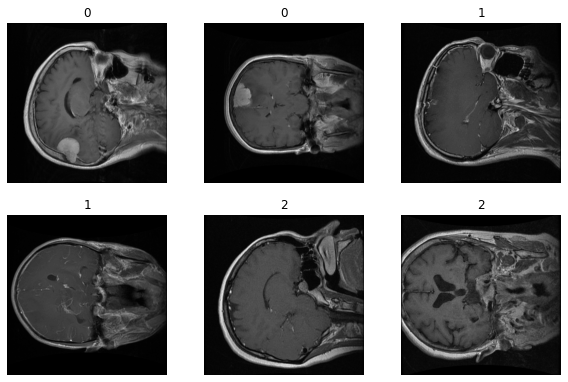

In [4]:
import random
# keys = ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']

images = [[], [], []]
labels = [[], [], []]
for i in range(1, 3064):
  f = h5py.File("{i}.mat".format(i=i), 'a')
  label = int(f['/cjdata/label'][0][0])
  image = np.array(f['/cjdata/image'])
  images[label-1].append(image)
  labels[label-1].append(label)

ind1, ind2 = random.sample(range(len(images[0])), 2)
ind3, ind4 = random.sample(range(len(images[1])), 2)
ind5, ind6 = random.sample(range(len(images[2])), 2)
sample_labels = [0, 0, 1, 1, 2, 2]
sample_indexes = [ind1, ind2, ind3, ind4, ind5, ind6]

plt.figure(figsize=(10, 10))
for i, index in enumerate(sample_indexes):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[sample_labels[i]][index], cmap='gray')
  plt.title(sample_labels[i])
  plt.axis("off")

## Split images to validation and train (10 pt)

Now, we want to save images in 3 different folders. Each folder should contain MRI images of one tumor type.

Then you should split data to train and validation. 80% of the data should be train and the rest should be validation.


In [ ]:
from sklearn.model_selection import train_test_split

train_dir = '/content/train/'
val_dir = '/content/val/'

!mkdir train/
!mkdir train/meningioma
!mkdir train/glioma
!mkdir train/pituitary
!mkdir val/
!mkdir val/meningioma
!mkdir val/glioma
!mkdir val/pituitary

X_train, X_test, y_train, y_test = train_test_split(np.array(images[0]), np.array(labels[0]), test_size=0.2, random_state=42)
[cv2.imwrite("train/meningioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/meningioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

X_train, X_test, y_train, y_test = train_test_split(np.array(images[1]), np.array(labels[1]), test_size=0.2, random_state=42)
[cv2.imwrite("train/glioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/glioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

X_train, X_test, y_train, y_test = train_test_split(np.array(images[2]), np.array(labels[2]), test_size=0.2, random_state=42)
[cv2.imwrite("train/pituitary/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/pituitary/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

### Data Preprocessing (15 pt)

Medical images datasets are smaller in size than the datasets available in other domains due to their limitations. One way to overcome the problem of lack of sufficient amount of training data is data augmentation.

There are many type of manipulations that we can use for this target. Here are a list of some augmentation techniques that you can use in this task:

Horizontal and vertical flips

Rotation

Zooming

Shifting

Shearing

Brightness

ZCA whitening

In [ ]:
train_dir = '/content/train'
val_dir =  '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2449 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


## Implementing 3 Different Classification Models

Now we want to design models for MRI image classification. Models that we want to use are these:

1- ResNet50

2- AlexNet

3- Multi-layer perceptron

### ResNet Model Design, image level (20pt)

Now it's time to create the model. Here we use Residual Network architecture composed of 50 layers for our model. Set the optimizer to 'Adam' and learning rate to '0.0003' for 200 epoches. You can change settings like LR untill getting better performance.


In this task we consentrate on the content of [this paper](https://doi.org/10.1016/j.artmed.2019.101779).

In [ ]:
model= ResNet50(include_top=False,
                   input_shape=(224, 224, 3))

ResNet_model = keras.models.Sequential()
ResNet_model.add(model)
ResNet_model.add(keras.layers.Flatten())
ResNet_model.add(keras.layers.Dense(512, activation='relu'))
ResNet_model.add(keras.layers.Dense(3, activation='sigmoid'))

In [ ]:
ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 74,969,987
Trainable params: 74,916,867
Non-trainable params: 53,120
_________________________________________________________________


### Train the ResNet50 model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.


In [ ]:
ResNet_model.compile(optimizer=Adam(0.0003),loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(),
                                                                                     tf.keras.metrics.Recall(),
                                                                                     tfa.metrics.F1Score(num_classes=3,
                                                                                                         average='macro',
                                                                                                         threshold=0.5)])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.000000001)
history = ResNet_model.fit(traindata, epochs=200, validation_data=valdata, callbacks=[learning_rate_reduction])

Epoch 1/200
77/77 [==============================] - 64s 634ms/step - loss: 1.7528 - accuracy: 0.6815 - precision: 0.5112 - recall: 0.8391 - f1_score: 0.6222 - val_loss: 1.1197 - val_accuracy: 0.4658 - val_precision: 0.3429 - val_recall: 0.9121 - val_f1_score: 0.4860 - lr: 3.0000e-04
Epoch 2/200
77/77 [==============================] - 47s 616ms/step - loss: 0.4153 - accuracy: 0.8277 - precision: 0.5164 - recall: 0.9829 - f1_score: 0.6763 - val_loss: 1.3025 - val_accuracy: 0.3958 - val_precision: 0.3485 - val_recall: 0.6971 - val_f1_score: 0.3371 - lr: 3.0000e-04
Epoch 3/200
77/77 [==============================] - 46s 593ms/step - loss: 0.3782 - accuracy: 0.8399 - precision: 0.5474 - recall: 0.9824 - f1_score: 0.7082 - val_loss: 1.2631 - val_accuracy: 0.4658 - val_precision: 0.3810 - val_recall: 0.7687 - val_f1_score: 0.3669 - lr: 3.0000e-04
Epoch 4/200
77/77 [==============================] - 46s 600ms/step - loss: 0.3508 - accuracy: 0.8616 - precision: 0.5909 - recall: 0.9726 - f1_s

###Loss and accuracy diagrams for ResNet50 (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

We trained the model for 200 epochs wirh lr=0.0003 and adam optimizer. The model shows 99% accuracy on training set and 93% accuracy on validation_set. precision in training set is about 69%, recal is 100% and f1-score is 81%. in validation data we have about 68% precision, 99% recal and 81% f1-score.

There is no overfitting as we cannot see increasing of val_loss and the model slightly converges.

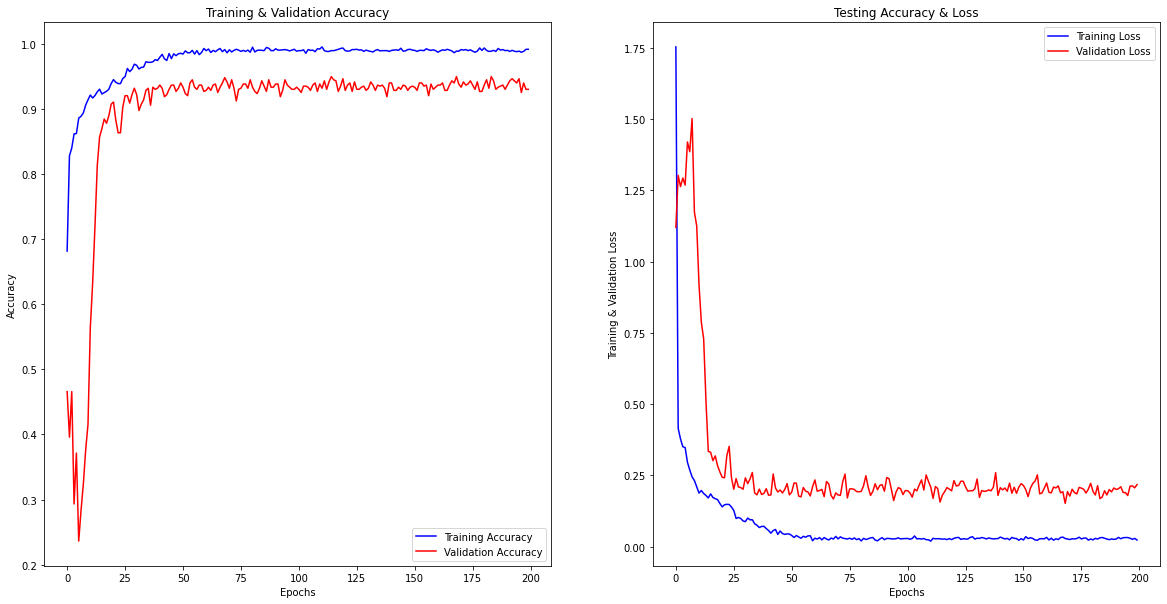

In [ ]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

###ResNet Model, Patient level (30 pt)


Here we want to repeat ResNet model in a different way. You should do all the steps again with a difference in spliting the data. In patient level you should pay attention that all the images from a patient should be either in train or validation.

So, do the spliting part of data with considering this point and then do all the steps again (design the model, train the model, plot accuracy and loss diagrams).


How different are the results?
Patient-level model shows lower accuracy, precisoin, recall and f1-score.

Which method do yo think is better? Which results are more reliable? Image level method or patient level method?

Petient level is more reliable beacause the model haven't seen any data of the patient in training but when the model train on image from one patient and we evaluate the model on that patient again, this makes the model less reliable. beacause the val_data is not completely unseen.

In [6]:
images = {}

for i in range(1, 3064):
  f = h5py.File("{i}.mat".format(i=i), 'a')
  pid = f['/cjdata/PID'][()]
  pid = ''.join([str(pid[i][0]) for i in range(pid.shape[0])])
  label = int(f['/cjdata/label'][0][0])
  image = np.array(f['/cjdata/image'])
  if not pid in images.keys():
    images[pid] = []
  image = cv2.resize(image, (224, 224))
  image = cv2.merge((image, image, image))
  images[pid].append((image, label-1))

In [7]:
import random

keys = list(images.keys())
values = list(images.values())

temp = list(zip(keys, values))
np.random.shuffle(temp)
keys, values = zip(*temp)

lens = [len(images[key]) for key in keys]
lens_cumsum = (np.cumsum(lens)/3063).tolist()
lens_cumsum

[0.002285341168788769,
 0.0075089781260202415,
 0.010120796604635978,
 0.01305909239307868,
 0.015670910871694418,
 0.016976820111002284,
 0.019262161279791055,
 0.02513875285667646,
 0.030035912504080966,
 0.03395364022200457,
 0.03591250408096637,
 0.04080966372837088,
 0.053215801501795626,
 0.059418870388507995,
 0.06594841658504734,
 0.06953966699314397,
 0.06986614430297095,
 0.07704864511916422,
 0.08292523669604962,
 0.08782239634345412,
 0.09174012406137773,
 0.0940254652301665,
 0.09859614756774404,
 0.10153444335618675,
 0.10871694417238002,
 0.11361410381978453,
 0.11949069539666993,
 0.12438785504407443,
 0.1325497877897486,
 0.13842637936663402,
 0.1446294482533464,
 0.14691478942213515,
 0.14822069866144302,
 0.15311785830884753,
 0.1573620633365981,
 0.16258570029382957,
 0.17009467841984982,
 0.17368592882794645,
 0.1740124061377734,
 0.17793013385569703,
 0.178256611165524,
 0.17956252040483187,
 0.18641854391119816,
 0.1939275220372184,
 0.20111002285341167,
 0.20274

In [8]:
lens_cumsum.index(0.8005223636957232)

185

In [9]:
import itertools

unzipped = list(zip(*list(itertools.chain.from_iterable(list(values)[:185]))))
X_train, y_train = np.array(unzipped[0]), np.array(unzipped[1])

unzipped = list(zip(*list(itertools.chain.from_iterable(list(values)[185:]))))
X_val, y_val = np.array(unzipped[0]), np.array(unzipped[1])

In [10]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_val = tf.keras.utils.to_categorical(y_val, 3)

In [11]:
train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow(X_train, y_train)

val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow(X_val, y_val)

In [12]:
model= ResNet50(include_top=False,
                   input_shape=(224, 224, 3))

ResNet_model = keras.models.Sequential()
ResNet_model.add(model)
ResNet_model.add(keras.layers.Flatten())
ResNet_model.add(keras.layers.Dense(512, activation='relu'))
ResNet_model.add(keras.layers.Dense(3, activation='sigmoid'))

ResNet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 74,969,987
Trainable params: 74,916,867
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
ResNet_model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(),
                                                                                     tf.keras.metrics.Recall(),
                                                                                     tfa.metrics.F1Score(num_classes=3,
                                                                                                         average='macro',
                                                                                                         threshold=0.5)])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5)
history = ResNet_model.fit(traindata, epochs=200, validation_data=valdata, callbacks=[learning_rate_reduction])

Epoch 1/200
77/77 [==============================] - 60s 556ms/step - loss: 5.2864 - accuracy: 0.5827 - precision: 0.5210 - recall: 0.7189 - f1_score: 0.5694 - val_loss: 54171.9492 - val_accuracy: 0.4681 - val_precision: 0.4557 - val_recall: 0.4760 - val_f1_score: 0.2671 - lr: 0.0010
Epoch 2/200
77/77 [==============================] - 44s 569ms/step - loss: 0.7459 - accuracy: 0.6418 - precision: 0.5260 - recall: 0.8330 - f1_score: 0.6344 - val_loss: 704.7087 - val_accuracy: 0.4409 - val_precision: 0.4427 - val_recall: 0.4441 - val_f1_score: 0.2099 - lr: 0.0010
Epoch 3/200
77/77 [==============================] - 42s 550ms/step - loss: 0.7006 - accuracy: 0.6635 - precision: 0.5311 - recall: 0.8609 - f1_score: 0.6491 - val_loss: 10.0721 - val_accuracy: 0.4489 - val_precision: 0.4397 - val_recall: 0.4952 - val_f1_score: 0.3295 - lr: 0.0010
Epoch 4/200
77/77 [==============================] - 40s 521ms/step - loss: 0.6724 - accuracy: 0.6972 - precision: 0.5330 - recall: 0.8814 - f1_score:

We trained the model for 200 epochs wirh lr=0.001 and adam optimizer. The model shows 93% accuracy on training set and 86% accuracy on validation_set. precision in training set is about 65%, recal is 98% and f1-score is 78%. in validation data we have about 62% precision, 93% recal and 73% f1-score.

There is no overfitting as we cannot see increasing of val_loss and the model slightly converges.

<ipython-input-16-4b8e278b940c>:14: RuntimeWarning: invalid value encountered in log
  ax[1].plot(epochs , np.log(np.log(history.history['loss'])) , 'b-' , label = 'Training Loss')


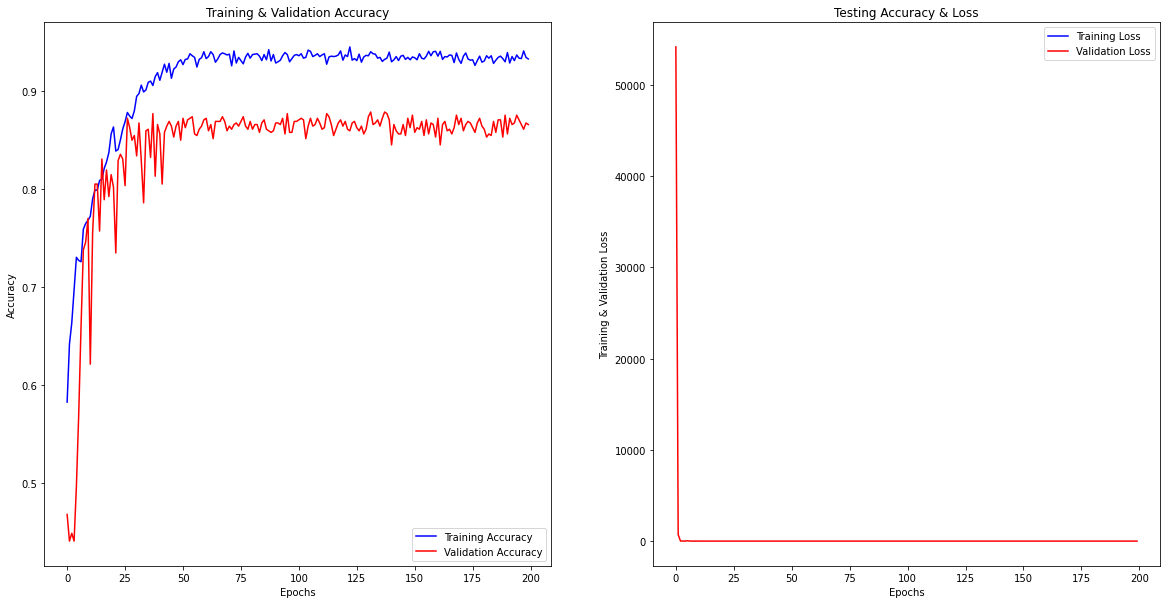

In [16]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

## 1. AlexNet Model Design (20 pt)

Now we want to test another model. We will use AlexNet here.

Run it for 100 epoches. You can change settings to get better performance.

set optimizer = 'Adam' and loss = 'categorical_crossentropy'.



In [21]:
train_dir = '/content/train'
val_dir =  '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2449 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [22]:
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))
  return model

AlexNet_model = AlexnetModel((224, 224, 3), 3)

In [23]:
AlexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 384)      

### Train the AlexNet model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.

In [24]:
AlexNet_model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(),
                                                                                     tf.keras.metrics.Recall(),
                                                                                     tfa.metrics.F1Score(num_classes=3,
                                                                                                         average='macro',
                                                                                                         threshold=0.5)])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5)
history = AlexNet_model.fit(traindata, epochs=100, validation_data=valdata, callbacks=[learning_rate_reduction])

Epoch 1/100
77/77 [==============================] - 41s 515ms/step - loss: 1.5058 - accuracy: 0.4614 - precision_1: 0.5164 - recall_1: 0.1221 - f1_score: 0.1529 - val_loss: 1.0118 - val_accuracy: 0.4756 - val_precision_1: 0.5051 - val_recall_1: 0.4072 - val_f1_score: 0.3474 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 36s 471ms/step - loss: 0.9524 - accuracy: 0.5480 - precision_1: 0.5839 - recall_1: 0.3650 - f1_score: 0.3425 - val_loss: 0.8915 - val_accuracy: 0.5537 - val_precision_1: 0.5857 - val_recall_1: 0.4788 - val_f1_score: 0.4064 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 35s 461ms/step - loss: 0.8754 - accuracy: 0.6027 - precision_1: 0.6389 - recall_1: 0.4941 - f1_score: 0.4293 - val_loss: 0.8756 - val_accuracy: 0.5993 - val_precision_1: 0.6475 - val_recall_1: 0.3860 - val_f1_score: 0.3737 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 35s 459ms/step - loss: 0.8422 - accuracy: 0.6198 - precision_1: 0.6561 - recall_

###Loss and accuracy diagrams for AlexNet (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

We trained the model for 100 epochs wirh lr=0.001 and adam optimizer. The model shows 89% accuracy on training set and 89% accuracy on validation_set. precision in training set is about 89%, recal is 87% and f1-score is 87%. in validation data we have about 89% precision, 88% recall and 88% f1-score.

There is no overfitting as we cannot see increasing of val_loss and the model slightly converges.

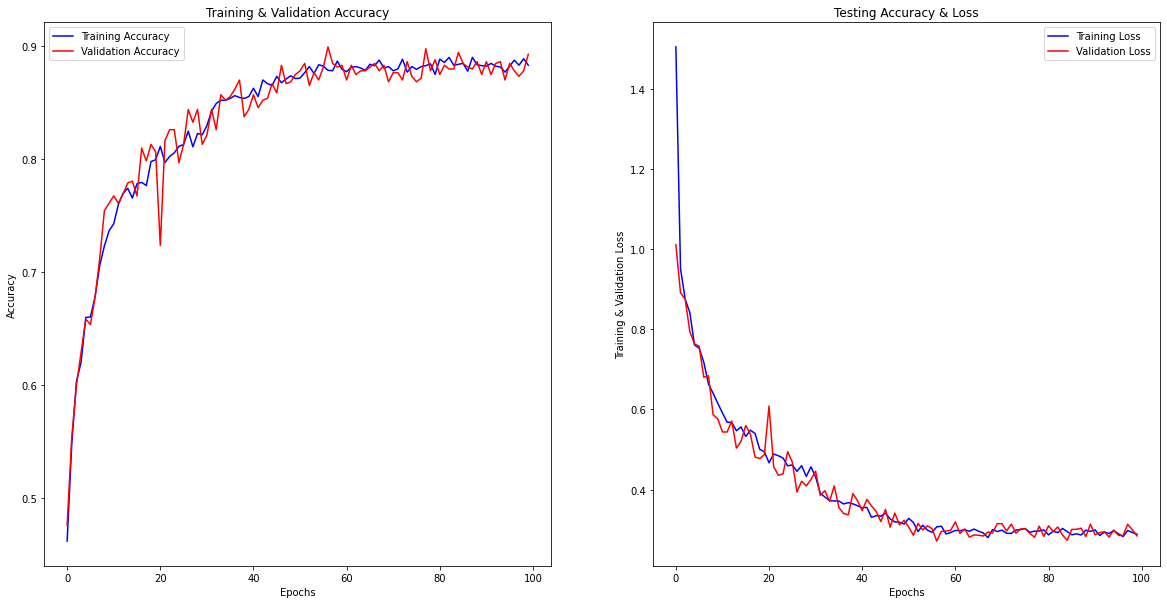

In [25]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

##Design the Multi-Layer Perceptron model (20 pt)

We want to implement a Multi layer perceptron deep network to classify our dataset too.

Do the steps as you did in other models.

In [33]:
image_size = 128
batch_size = 32

train_dir = '/content/train'
val_dir = '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir, target_size=(image_size,image_size))

val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =90,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(image_size,image_size))

Found 2449 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [34]:
MLP_model = Sequential()
MLP_model.add(Flatten(input_shape = (image_size, image_size, 3)))
MLP_model.add(Dense(2048, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(1024, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(512, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(3, activation = 'softmax'))

In [30]:
MLP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_9 (Dense)             (None, 2048)              100665344 
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

###Train the model (10pt)

In [35]:
MLP_model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(),
                                                                                     tf.keras.metrics.Recall(),
                                                                                     tfa.metrics.F1Score(num_classes=3,
                                                                                                         average='macro',
                                                                                                         threshold=0.5)])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5,)
history = MLP_model.fit(traindata, epochs=100, validation_data=valdata, callbacks=[learning_rate_reduction])

Epoch 1/100
77/77 [==============================] - 19s 231ms/step - loss: 12.9002 - accuracy: 0.4042 - precision_3: 0.4083 - recall_3: 0.3916 - f1_score: 0.3636 - val_loss: 1.3778 - val_accuracy: 0.2394 - val_precision_3: 0.2477 - val_recall_3: 0.2231 - val_f1_score: 0.1655 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 17s 218ms/step - loss: 1.1703 - accuracy: 0.4626 - precision_3: 0.4913 - recall_3: 0.3577 - f1_score: 0.3564 - val_loss: 1.0798 - val_accuracy: 0.4658 - val_precision_3: 0.4702 - val_recall_3: 0.4625 - val_f1_score: 0.2127 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 17s 227ms/step - loss: 1.0729 - accuracy: 0.4671 - precision_3: 0.5109 - recall_3: 0.3263 - f1_score: 0.3084 - val_loss: 1.0205 - val_accuracy: 0.4446 - val_precision_3: 0.4980 - val_recall_3: 0.2068 - val_f1_score: 0.2802 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 17s 221ms/step - loss: 1.0202 - accuracy: 0.5125 - precision_3: 0.5516 - recall

We trained the model for 100 epochs wirh lr=0.001 and adam optimizer. The model shows 57% accuracy on training set and 57% accuracy on validation_set. precision in training set is about 61%, recall is 45% and f1-score is 39%. in validation data we have about 62% precision, 42% recal and 39% f1-score.

There is no overfitting as we cannot see increasing of val_loss but the model cannot classify properly and accuracies are much less than previous models.

###Loss and accuracy diagrams for multi-layer perceptron (10 pt)


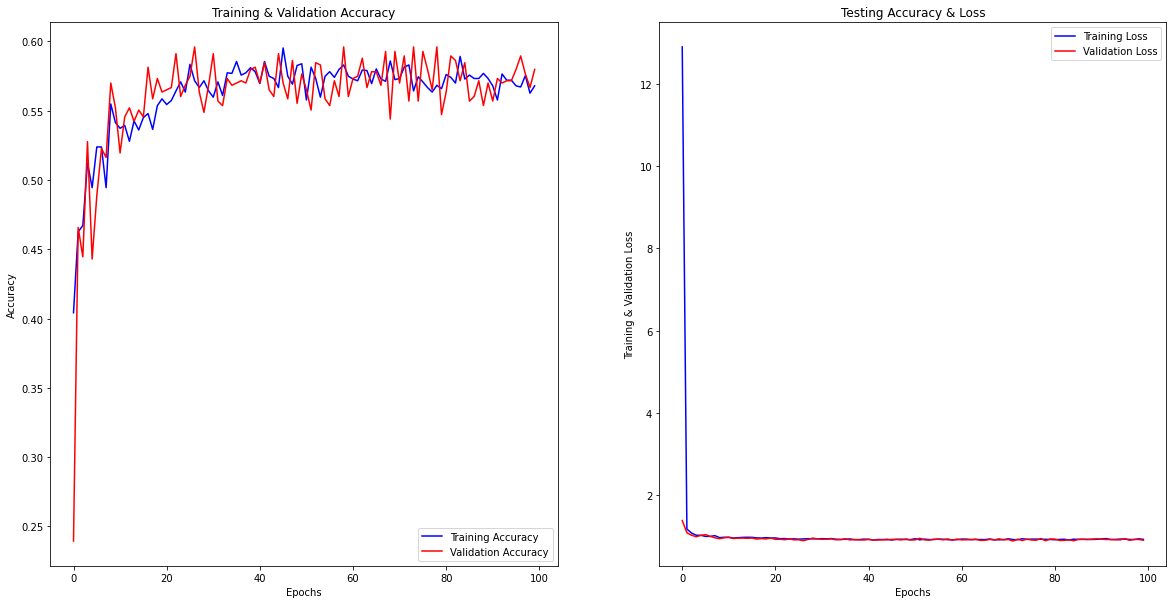

In [41]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

####Now answer these questions:

1- How close are your answers to those in the paper?
The ResNet model shows 94% accuracy in Image-level and about 88% accuracy in Paitien-level. Accuracies in selected papaers are up to 99%, specifically ResNet model in [Çinar and Yildirim, 2020 Classify into tumor and non-tumor] shows 97% accuracy, [Siar and Teshnehlab 2019 Detect (tumor/nontumor)] achived 84%, 92% and 97% acuuracy using different data augmentation(GAN), [ Liu et al. 2019 Classification] using GResNet shows 95% accuracy and [Antony et al. 2017 Classify into HG and LG] shows 97% accuracy. 

Our AlexNet model achieved 88% accuracy, but in reviwed papers such as [ Amin et al. 2019 Detect (benign/malignant) + seg] achieved 99% accuracy, [1 Adu et al. 2019 Detect (normal + tumor brain)] shows 99%, [ Afshar et al. 2019 Classify + seg] achieved 100% accuracy and [Seetha and Raja 2018 Classify into tumor non-tumor] shows 97% accuracy. 

2- Why do you think they aren't close if they aren't?
Data augmentation and pre-processing is so important in deep learning models. Most of the reviewed papers, specially recent ones are focusing on improvement of data augmentation to get better peformance.

3- What suggestions do you have for improving any of these methods?
According to analysis algorithms and models used in reviewed papers, we could use data augmentation techniques to boost out model, prevent overfitting, regularization and generalization. 

Some alternatives and data augmentation we could apply is using patch extraction, segmentation techniques and extract important areas, noise smoothing techniques such as applying different filters like median filters. we can change out model and use modified and improved versions of networks.

we can combine Deep Learning and statistical model for boosting, or add Attention Module to networks and use hyper Column technique to generalize model. we can use resized and cropped images from the center to remove the background information. And using GAN helpe data augmentation part to output more realistic images.

4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness?
AlexNet and ResNet model have good performance on the model but MLP is a simple model and coudln't perfectly classify datatset. And you can see this through models used in papers. MLP is not a good model for this purpose, AlexNet and ResNet models are better but they were used until 2018-2019 and now they are not enough and people are using different models and using Autoencoders and GANs and different augmentation techniques. 

5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.
When we train a model on a specific dataset, we should notice how much our data is generalized and we are overfitting or not. A balance can be created using model regularization to achieve generalization and avoid overfitting. 

if we have a complex model, the model probably fail in other datasets. So one of the techniques to generalize model is don't use comlex model and add a regularization term. In deep learning, changing network structure by reducing the number of network parameters could do the trick. For example here we used AlexNet and ResNet as two standard model and use MLP with reasonable number of layers. Also we use Learning rate scheduler to prevent overfitting and more generalized model.

To have a good model we should train model on a diverse dataset. This helps models to be trained on diverse dataset and have a good performance on other data. diversity in a dataset make it more like real-world data. Here our dataset contains small amount of images and out models probably are not perfectly generalized and may fail on other clinical images. but we have diverse images and images are from all types of sagittal, coronal and axial and this make our model more robust.

From the other hand we should define proper validation datasets. having a perfect validation set means we will have a really good representation of real-world data and we can easily determine model is generalized or not. It's important to have validation set as an unseen data. when we are working with data in image-level, our models may see the data of a patients in training set and we evaluate the model with image of same patient.